## Experiments for Bayes by Hypernet on Toy Data

In [1]:
# generate toy data
import numpy as np
import time

rng = np.random.RandomState()

data_x = rng.uniform(low=-4, high=4, size=(20,))
data_y = data_x**3 + rng.normal(loc=0, scale=9, size=(20,))

linspace = np.linspace(-6, 6, num=100)

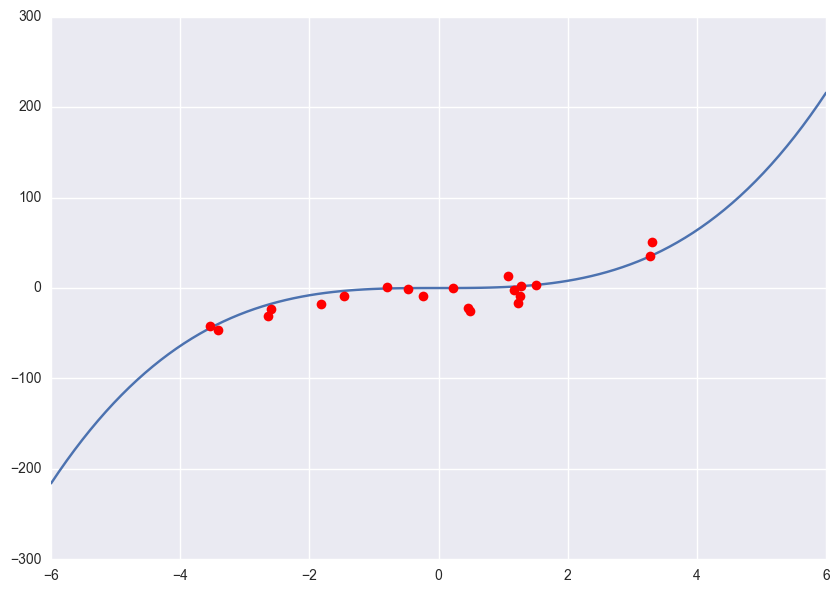

In [2]:
# plot toy data
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
plt.plot(linspace, linspace ** 3)
plt.plot(data_x, data_y, 'ro')
plt.show()

In [3]:
# import some stuff
from __future__ import division, print_function

import os

# set gpu device - only important for multi gpu systems
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf

from tqdm import tqdm
import pandas as pd

In [4]:
# function to build network dependent on mode
def get_net(mode, ops):
    with tf.variable_scope('net'):
        x = tf.placeholder(tf.float32, [None, 1])
        y = tf.placeholder(tf.float32, [None, 1])
        
        ops['x'] = x
        ops['y'] = y
        
        if mode == 'implicit':
            g1 = ops['g1']
            g2 = ops['g2']
            
            v1 = tf.reshape(g1,[1, 100])

            
            x = tf.matmul(x, v1)

            x = x + tf.reshape(g2, [1, 100])
            x = tf.nn.relu(x)
            
            # layer 2
            v2 = tf.get_variable('v2', [100, 1], tf.float32,
                                tf.random_normal_initializer(0, 0.05))
            
            x = tf.matmul(x, v2)
            
            b2 = tf.get_variable('b2', [1], tf.float32, tf.constant_initializer())
            
            x = x + tf.reshape(b2, [1, 1])
        elif mode == 'bbb':
            
            # layer 1
            w1_loc = tf.get_variable('w1_loc', [1, 100], tf.float32,
                                tf.truncated_normal_initializer(0, 0.05))
            
            w1_log_scale_sq = tf.get_variable('w1_log_scale_sq', [1, 100], tf.float32,
                                tf.truncated_normal_initializer(1., 0.05))

            w1 = tf.random_normal((1, 100)) * tf.sqrt(tf.exp(w1_log_scale_sq)) + w1_loc
            
            b1_loc = tf.get_variable('b1_loc', [100], tf.float32,
                                tf.truncated_normal_initializer(0, 0.05))
            
            b1_log_scale_sq = tf.get_variable('b1_log_scale_sq', [100], tf.float32,
                                tf.truncated_normal_initializer(1., 0.05))

            b1 = tf.random_normal((100,)) * tf.sqrt(tf.exp(b1_log_scale_sq)) + b1_loc
            
            x = tf.matmul(x, w1) + tf.reshape(b1, [1, 100])
            x = tf.nn.relu(x)
            
            # layer 2
            w2_loc = tf.get_variable('w2_loc', [100, 1], tf.float32,
                                tf.truncated_normal_initializer(0, 0.05))
            
            w2_log_scale_sq = tf.get_variable('w2_log_scale_sq', [100, 1], tf.float32,
                                tf.truncated_normal_initializer(1., 0.05))

            w2 = tf.random_normal((100, 1)) * tf.sqrt(tf.exp(w2_log_scale_sq)) + w2_loc
            
            b2_loc = tf.get_variable('b2_loc', [1], tf.float32,
                                tf.truncated_normal_initializer(0, 0.05))
            
            b2_log_scale_sq = tf.get_variable('b2_log_scale_sq', [1], tf.float32,
                                tf.truncated_normal_initializer(1., 0.05))

            b2 = tf.random_normal((1,)) * tf.sqrt(tf.exp(b2_log_scale_sq)) + b2_loc
            
            
            
            x = tf.matmul(x, w2) + tf.reshape(b2, [1, 1])
            
            
            kl_loss = tf.add_n([tf.reduce_sum(1 + scale - tf.square(loc) - tf.exp(scale)) for loc, scale in
                                [(w1_loc, w1_log_scale_sq), (b1_loc, b1_log_scale_sq), (w2_loc, w2_log_scale_sq),
                                (b2_loc, b2_log_scale_sq)]])
            
                       
            ops['kl_loss'] = - 0.5 * kl_loss
            
        elif mode == 'dropout':
            x = tf.layers.dense(inputs=x, units=100, activation=tf.nn.relu)
            x = tf.nn.dropout(x, 0.5)

            x = tf.layers.dense(inputs=x, units=1)
        else:
            x = tf.layers.dense(inputs=x, units=100, activation=tf.nn.relu)

            x = tf.layers.dense(inputs=x, units=1)

        ops['pred'] = x
        
        return ops

# function to build hypernetwork
def get_h_net(num_noise=1):
    with tf.variable_scope('h_net'):
        
        w1_c = tf.constant([1., 0.])
        w2_c = tf.constant([0., 1.])

        noise = tf.random_normal((num_noise, ))

        w1_z = tf.reshape(tf.concat([w1_c, noise], 0), (1, num_noise + 2))
        w2_z = tf.reshape(tf.concat([w2_c, noise], 0), (1, num_noise + 2))

        w_z = tf.concat([w1_z, w2_z], 0)

        z = tf.layers.dense(inputs=w_z, units=64)
        z = tf.nn.relu(z)
        
        z = tf.layers.dense(inputs=w_z, units=256)
        z = tf.nn.relu(z)
        
        z = tf.layers.dense(inputs=w_z, units=100)

        w1 = z[0, :]
        w2 = z[1, :]
        
        return [w1, w2, tf.reshape(tf.concat([w1, w2], 0), (200, 1))]

# function to build discriminator to estimate density ratio
def get_d_net(gens):
    with tf.variable_scope('d_net'):
        # scale mixture prior
        ds = tf.contrib.distributions
        mix = 0.7
        bimix_gauss = ds.Mixture(
          cat=ds.Categorical(probs=[mix, 1.-mix]),
          components=[
            ds.Normal(loc=0., scale=0.01),
            ds.Normal(loc=0., scale=5.),
        ])
        
        noise = bimix_gauss.sample(((200), 1))
        
        all_t = tf.concat((gens, noise), 0)
        
        d = tf.layers.dense(inputs=all_t, units=20)
        d = tf.nn.relu(d)
        
        d = tf.layers.dense(inputs=d, units=20)
        d = tf.nn.relu(d)
        
        d = tf.layers.dense(inputs=d, units=1)
        
        return d[:100], d[100:]

In [5]:
# dataframe to hold results
cols = ['x', 'y', 'mode', 'mc']
prediction_df = pd.DataFrame(columns=cols)
for mode in ['bbb', 'dropout', 'implicit', 'vanilla']:

    tf.reset_default_graph()

    ops = {}
    # if implicit get hypetnetwork generated weights
    if mode == 'implicit':
        w1, w2, gens = get_h_net()

        g_d, n_d = get_d_net(gens)

        ops = {'g1': w1, 'g2': w2}

        d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'd_net')
        g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'h_net')

    # get network ops
    ops = get_net(mode, ops)

    net_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'net')

    # build distribution with fixed scale for loss 
    n = tf.distributions.Normal(loc=0., scale=9.)
    
    # build loss
    loss = tf.reduce_mean(-1 * n.log_prob(ops['pred'] - ops['y']))

    opt = tf.train.AdamOptimizer(0.1, epsilon=1e-5)

    if mode == 'implicit': # build custom training ops for implicit
        loss_d = (- tf.reduce_mean(tf.log(1 - tf.nn.sigmoid(n_d) + 1e-8, name='log_n_d'))
                  - tf.reduce_mean(tf.log(tf.nn.sigmoid(g_d) + 1e-8, name='log_g_d')))

        # apply gradient clipping
        gvs = opt.compute_gradients(loss_d, var_list=d_vars)
        capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gvs if grad is not None]
        d_optimiser = opt.apply_gradients(capped_gvs)

        g_logits_m = tf.reduce_mean(g_d)

        loss_g = g_logits_m + loss

        g_optimiser = opt.minimize(loss_g, var_list=g_vars+net_vars)

        d_n_acc = tf.reduce_mean(tf.cast(tf.nn.sigmoid(n_d) < 0.5, tf.float32))
        d_g_acc = tf.reduce_mean(tf.cast(tf.nn.sigmoid(g_d) >= 0.5, tf.float32))
    elif mode == 'bbb':
        optimiser = opt.minimize(loss + ops['kl_loss'])
    else:
        optimiser = opt.minimize(loss)

    # build function to hold predictions
    pred = ops['pred']

    # build op to initialise the variables
    init = tf.global_variables_initializer()

    numerics = tf.add_check_numerics_ops()
    
    s = tf.Session()

    # initialise the weights
    s.run(init)
    
    # run discriminator to give better gradients
    if mode == 'implicit':
        for _ in range(100):
            s.run(d_optimiser)

    from tqdm import trange
    with trange(40) as pbar: # run for 40 epochs
        for i in pbar: #300 epochs
            # get batch from dataset
            

            if mode == 'implicit':
                # run discriminator to give better gradients
                for _ in range(20):
                    s.run(d_optimiser)

                d_loss, g_loss, l_loss, np_d, np_g, _, _ = s.run([loss_d, g_logits_m, loss,
                                                                  d_n_acc, d_g_acc, g_optimiser, numerics],
                                                                     feed_dict={ops['x']: data_x[:, np.newaxis],
                                                                                ops['y']: data_y[:, np.newaxis]})

                pbar.set_postfix(d_loss=d_loss, g_loss=g_loss,
                                 l_loss=l_loss, d_n_acc=np_d, d_g_acc=np_g)
            elif mode == 'bbb':
                l_loss, kl_loss, _ = s.run([loss, ops['kl_loss'], optimiser],
                                          feed_dict={ops['x']: data_x[:, np.newaxis], ops['y']: data_y[:, np.newaxis]})
                pbar.set_postfix(ce=l_loss, kl_loss=kl_loss)
            else:
                l_loss, _ = s.run([loss, optimiser],
                                          feed_dict={ops['x']: data_x[:, np.newaxis], ops['y']: data_y[:, np.newaxis]})

                pbar.set_postfix(ce=l_loss)
    
    # run predictions after training
    if mode == 'dropout' or mode == 'implicit' or mode == 'bbb':
        mcsteps = 10
        for mc in range(mcsteps):
            predictions = s.run(ops['pred'], {ops['x']: linspace[:, np.newaxis]})[:, 0]
            new_df = pd.DataFrame(columns=cols, data=zip(linspace, predictions,
                                                     [mode]*len(linspace), [mc]*len(linspace)))
            
            prediction_df = pd.concat([prediction_df, new_df])

    else:
        predictions = s.run(ops['pred'], {ops['x']: linspace[:, np.newaxis]})[:, 0]
        new_df = pd.DataFrame(columns=cols, data=zip(linspace, predictions,
                                                     [mode]*len(linspace), [0]*len(linspace)))
        
        prediction_df = pd.concat([prediction_df, new_df])
        
    

100%|██████████| 40/40 [00:00<00:00, 828.26it/s, ce=3.76]


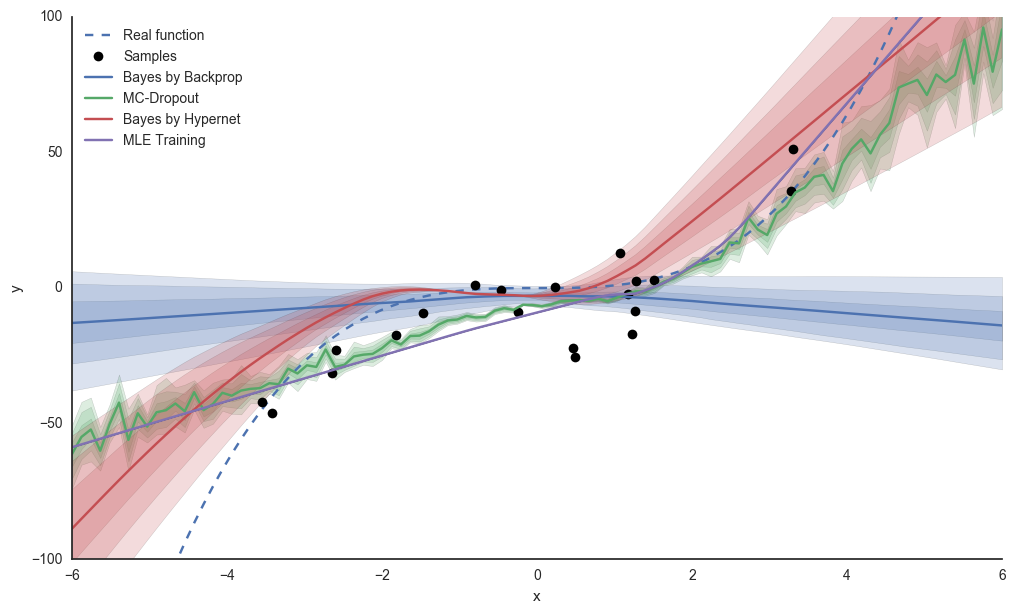

In [6]:
# plot results
t = {'bbb': 'Bayes by Backprop', 'implicit': 'Bayes by Hypernet', 'dropout': 'MC-Dropout', 'vanilla': 'MLE Training'}

prediction_df['title'] = [t[f] for f in prediction_df['mode']]
sns.set_style('white')

plt.figure(figsize=(12, 7))
plt.plot(linspace, linspace ** 3, '--', label='Real function')
plt.plot(data_x, data_y, 'o', color='black', label='Samples')
sns.tsplot(prediction_df, time='x', value='y', condition='title', unit='mc', ci=[68.27, 95.45, 99.73], n_boot=1000,)
plt.ylim(-100, 100)
l = plt.legend(loc=0)
l.set_title('')
sns.despine()
plt.show()